# 2. Home Credit Default Risk - Data Analysis

In [1]:
import pandas as pd 
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from six.moves import cPickle as pickle

In [2]:
%qtconsole

In [3]:
import os
data_path="../data/pickles"

In [4]:
application_train = pickle.load(open(os.path.join(data_path, "application_train.pickle"), "rb"))
application_test = pickle.load(open(os.path.join(data_path, "application_test.pickle"), "rb"))

## Data model

The structure of the data is explained in the following image (from the data description on the competition page)

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>

The dataframe *application_train* and *application_test* contains the loan and loan applicants. The dataframe *bureau* contains the application data from other loans that the client took from other credit institutions and were reported to the credit bureau. The dataframe *previous_applications* contains information about previous loans at **Home Credit** by the same client, previous loans information and client information at the time of the loan (there is a line in the dataframe per previous loan application).

**SK_ID_CURR** is connecting the dataframes *application_train*|*test* with *bureau*, *previous_application* and also with dataframes *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_PREV** connects dataframe *previous_application* with *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_BUREAU** connects dataframe *bureau* with dataframe *bureau_balance*.

## Util functions

In [5]:
def print_data_dimensions(train_df, test_df):
    print("Shape TRAIN: {}".format(train_df.shape))
    print("Shape  TEST: {}".format(test_df.shape))

## Shape of the Data

In [6]:
print_data_dimensions(application_train, application_test)

Shape TRAIN: (307511, 122)
Shape  TEST: (48744, 121)


In [7]:
application_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
265774,407867,0,Cash loans,M,Y,Y,0,157500.0,187704.0,11610.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
293761,440339,0,Revolving loans,F,N,Y,0,157500.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
26820,131174,0,Cash loans,M,N,Y,0,112500.0,348826.5,22842.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [8]:
#corr = application_train.corr()

In [9]:
# remove target column from application_train to have same structure like application_test
prep_train = application_train.copy()
prep_test = application_test.copy()

# Data Analysis

In [10]:
# Encode with LabelEncoder
from sklearn.preprocessing import LabelEncoder

### NAME_CONTRACT_TYPE

Identification if loan is cash or revolving

__Cash loans__: Credit that is payed monthly. (Normal credit)

__Revolving loans__: Specific amount of credit is available. Customer can pay some amount back. Max amount cannot be excided.

In [11]:
col_to_analyse = 'NAME_CONTRACT_TYPE'

In [12]:
application_train[col_to_analyse].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [13]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Cash loans         255011
Revolving loans     27675
Name: NAME_CONTRACT_TYPE, dtype: int64

In [14]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Cash loans         23221
Revolving loans     1604
Name: NAME_CONTRACT_TYPE, dtype: int64

In [15]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_CONTRACT_TYPE, 
application_train: 0 
application_test: 0.


In [16]:
# Create a label encoder object
le_NAME_CONTRACT_TYPE = LabelEncoder()
le_NAME_CONTRACT_TYPE.fit(prep_train[col_to_analyse])

LabelEncoder()

In [17]:
prep_train.loc[:,col_to_analyse] = le_NAME_CONTRACT_TYPE.transform(prep_train.loc[:,col_to_analyse])
prep_test.loc[:,col_to_analyse] = le_NAME_CONTRACT_TYPE.transform(prep_test.loc[:,col_to_analyse])

In [18]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.030895908161047654

In [19]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307511, 122)
Shape  TEST: (48744, 121)


### CODE_GENDER

Gender of the client.

__F__: Female

__M__: Men

__XNA__: Unknown

In [20]:
col_to_analyse = 'CODE_GENDER'

In [21]:
application_train[col_to_analyse].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [22]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

F      188278
M       94404
XNA         4
Name: CODE_GENDER, dtype: int64

In [23]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

F    14170
M    10655
Name: CODE_GENDER, dtype: int64

It's strange that the column CODE_GENDER contains 3 unique values (expected were only 2). We see that the value XNA only appears in 4 data rows. This seems to be some wrong data or leck of information. Let's see how much percent of the data it is. 

In [24]:
xna_percent =  application_train.CODE_GENDER.value_counts()['XNA'] / application_train.size
print("XNA in Percentage: {}%".format(xna_percent))

XNA in Percentage: 1.0662020300380031e-07%


Because of the small percentage we decide to remove those rows.

In [25]:
index_xna_rows = prep_train.CODE_GENDER != 'XNA'
prep_train = prep_train[index_xna_rows].copy()

index_xna_rows = prep_test.CODE_GENDER != 'XNA'
prep_test = prep_test[index_xna_rows].copy()

In [26]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for CODE_GENDER, 
application_train: 0 
application_test: 0.


In [27]:
le_CODE_GENDER = LabelEncoder()
le_CODE_GENDER.fit(prep_train[col_to_analyse])

LabelEncoder()

In [28]:
prep_train.loc[:,col_to_analyse] = le_CODE_GENDER.transform(prep_train.loc[:,col_to_analyse])
prep_test.loc[:,col_to_analyse] = le_CODE_GENDER.transform(prep_test.loc[:,col_to_analyse])

In [29]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.05471012101772599

In [30]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307507, 122)
Shape  TEST: (48744, 121)


### FLAG_OWN_CAR

Flag if the client owns a car.

__N__: no

__Y__: yes

In [31]:
col_to_analyse = 'FLAG_OWN_CAR'

In [32]:
application_train[col_to_analyse].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [33]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

N    185675
Y     97011
Name: FLAG_OWN_CAR, dtype: int64

In [34]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

N    17249
Y     7576
Name: FLAG_OWN_CAR, dtype: int64

In [35]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_OWN_CAR, 
application_train: 0 
application_test: 0.


In [36]:
le_FLAG_OWN_CAR = LabelEncoder()
le_FLAG_OWN_CAR.fit(prep_train[col_to_analyse])

LabelEncoder()

In [37]:
prep_train[col_to_analyse] = le_FLAG_OWN_CAR.transform(prep_train[col_to_analyse])
prep_test[col_to_analyse] = le_FLAG_OWN_CAR.transform(prep_test[col_to_analyse])

In [38]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.021849824422382588

In [39]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307507, 122)
Shape  TEST: (48744, 121)


### FLAG_OWN_REALTY

Flag if client owns a house or flat.

__N__: no

__Y__: yes

In [40]:
col_to_analyse = 'FLAG_OWN_REALTY'

In [41]:
application_train[col_to_analyse].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

In [42]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Y    196329
N     86357
Name: FLAG_OWN_REALTY, dtype: int64

In [43]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Y    16983
N     7842
Name: FLAG_OWN_REALTY, dtype: int64

In [44]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_OWN_REALTY, 
application_train: 0 
application_test: 0.


In [45]:
le_FLAG_OWN_REALTY = LabelEncoder()
le_FLAG_OWN_REALTY.fit(prep_train[col_to_analyse])

LabelEncoder()

In [46]:
prep_train[col_to_analyse] = le_FLAG_OWN_REALTY.transform(prep_train[col_to_analyse])
prep_test[col_to_analyse] = le_FLAG_OWN_REALTY.transform(prep_test[col_to_analyse])

In [47]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0061458472568773

In [48]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307507, 122)
Shape  TEST: (48744, 121)


### FLAG_OWN_REALTY

Flag if client owns a house or flat.

__N__: no

__Y__: yes

In [49]:
col_to_analyse = 'FLAG_OWN_REALTY'

In [50]:
application_train[col_to_analyse].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

In [51]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Y    196329
N     86357
Name: FLAG_OWN_REALTY, dtype: int64

In [52]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Y    16983
N     7842
Name: FLAG_OWN_REALTY, dtype: int64

In [53]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_OWN_REALTY, 
application_train: 0 
application_test: 0.


In [54]:
le_FLAG_OWN_REALTY = LabelEncoder()
le_FLAG_OWN_REALTY.fit(prep_train[col_to_analyse])

LabelEncoder()

In [55]:
prep_train[col_to_analyse] = le_FLAG_OWN_REALTY.transform(prep_train[col_to_analyse])
prep_test[col_to_analyse] = le_FLAG_OWN_REALTY.transform(prep_test[col_to_analyse])

In [56]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0061458472568773

In [57]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307507, 122)
Shape  TEST: (48744, 121)


### CNT_CHILDREN

Number of children the client has.

__numeric value__

In [58]:
col_to_analyse = 'CNT_CHILDREN'

In [59]:
application_train[col_to_analyse].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

In [60]:
#application_train[col_to_analyse].plot.density()

In [61]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

0     198762
1      55665
2      24416
3       3359
4        374
5         77
6         15
7          7
14         3
19         2
12         2
10         2
8          2
Name: CNT_CHILDREN, dtype: int64

In [62]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

0     16609
1      5454
2      2333
3       358
4        55
5         7
6         6
9         2
11        1
Name: CNT_CHILDREN, dtype: int64

In [63]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for CNT_CHILDREN, 
application_train: 0 
application_test: 0.


In [64]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.019189112947537213

In [65]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307507, 122)
Shape  TEST: (48744, 121)


### AMT_INCOME_TOTAL

Income of the client.

__numeric value__

In [66]:
col_to_analyse = 'AMT_INCOME_TOTAL'

In [67]:
application_train[col_to_analyse].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

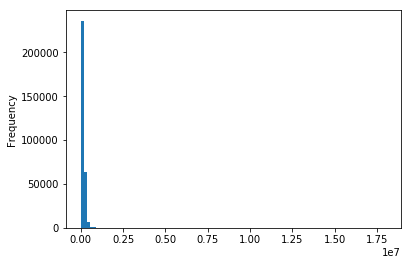

In [68]:
index_to_drop = prep_train[prep_train[col_to_analyse] > 1.0e+8].index
prep_train[col_to_analyse].drop(index_to_drop).plot.hist(bins=100)

In [69]:
prep_train.iloc[index_to_drop]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
95648,211040,0,0,0,1,1,1,103500.0,333337.5,22405.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


It seems that the highest value for AMT_INCOME_TOTAL must be a outlier. It makes no sens for a person with such a high income to have difficulties to pay back the loan or even affort a own car. That´s why we remove the outlier manually.

In [70]:
prep_train = prep_train.drop(index_to_drop)

In [71]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for AMT_INCOME_TOTAL, 
application_train: 0 
application_test: 0.


In [72]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.02045944469451711

In [73]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 122)
Shape  TEST: (48744, 121)


### AMT_CREDIT

Credit amount of the loan.

__numeric value__

In [74]:
col_to_analyse = 'AMT_CREDIT'

In [75]:
application_train[col_to_analyse].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

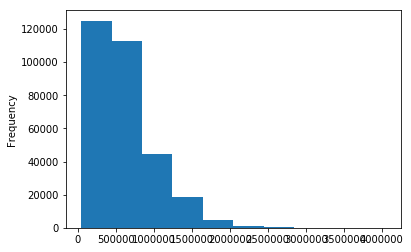

In [76]:
application_train[col_to_analyse].plot.hist(bins=10)

In [77]:
#application_train[col_to_analyse].plot.density()

In [78]:
# Show missing values for train dataset
print("Missing Values for {}, \napplication_train: {} \napplication_test: {}.".format(col_to_analyse, 
                                                                            application_train[col_to_analyse].isnull().sum(),
                                                                            application_test[col_to_analyse].isnull().sum()))

Missing Values for AMT_CREDIT, 
application_train: 0 
application_test: 0.


In [79]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.03037084231284032

In [80]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 122)
Shape  TEST: (48744, 121)


### AMT_ANNUITY

How much the client paid back every year.

__numeric value__

In [81]:
col_to_analyse = 'AMT_ANNUITY'

In [82]:
application_train[col_to_analyse].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

The max value seems to be a little bit high so we will look at this specific client to verify if it is an oulier or not.

In [83]:
application_train[application_train[col_to_analyse] > 250000]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
17948,120926,0,Cash loans,M,Y,N,2,783000.0,4050000.0,258025.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that this client has a plausible income for this annuity.

We calculated 2 new features which seem to have a relativ high correlation with the target. We should analyse later on if those features brings some gain.

In [84]:
(application_train.AMT_ANNUITY / application_train.AMT_CREDIT).corr(application_train.TARGET)

0.012703610951500717

In [85]:
(application_train.AMT_CREDIT / application_train.AMT_ANNUITY).corr(application_train.TARGET)

-0.03210151683730928

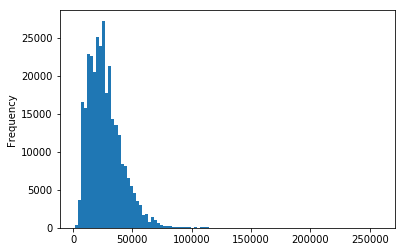

In [86]:
application_train[col_to_analyse].plot.hist(bins=100)

In [87]:
#application_train[col_to_analyse].plot.density()

In [88]:
# Show missing values
application_train[application_train[col_to_analyse].isnull()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
75873,187985,0,Cash loans,M,Y,N,0,144000.0,219249.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,11.0
227939,364022,0,Cash loans,F,N,Y,0,315000.0,628069.5,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
47531,155054,0,Cash loans,M,N,N,0,180000.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
55025,163757,0,Cash loans,F,N,N,0,162000.0,296280.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
50035,157917,0,Cash loans,F,N,N,0,94500.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
241835,379997,0,Cash loans,F,N,N,0,315000.0,1483231.5,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
89343,203726,0,Cash loans,F,Y,N,0,90000.0,157500.0,NaN,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0
207186,340147,0,Cash loans,M,N,N,0,171000.0,486000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,1.0,0.0,2.0
59934,169487,0,Cash loans,M,Y,N,0,202500.0,360000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,6.0
239329,377174,0,Cash loans,F,N,Y,0,157500.0,792000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [89]:
# Show missing values for train dataset
print("Missing Values for AMT_ANNUITY, application_train: {} prep_train: {}.".format(application_train[col_to_analyse].isnull().sum(),
                                                                                     prep_train[col_to_analyse].isnull().sum()))

Missing Values for AMT_ANNUITY, application_train: 12 prep_train: 12.


In [90]:
# We have entries where the AMT_ANNUITY is missing.
# We decide to fill those missing values with values from entries that are similar regarding
# AMT_INCOME_TOTAL, AMT_CREDIT and TARGET.
def handle_missing_values_AMT_ANNUITY(dataset_, threshold = 0.05):
    # to not modify the passed dataset
    dataset = pd.DataFrame.copy(dataset_)
    col_to_analyse = "AMT_ANNUITY" 
    SK_IDS_CURR = dataset[dataset[col_to_analyse].isnull()].SK_ID_CURR.values
    
    for SK_ID_CURR in SK_IDS_CURR:
        # set filter for client with SK_ID_CURR and AMT_ANNUITY == NaN
        AMT_CREDIT_FILTER = dataset[dataset.SK_ID_CURR == SK_ID_CURR].AMT_CREDIT.iloc[0]
        AMT_INCOME_TOTAL_FILTER = dataset[dataset.SK_ID_CURR == SK_ID_CURR].AMT_INCOME_TOTAL.iloc[0]

       # get mean of those entries that are most simlilar to the one with SK_ID_CURR
        calc_mean = application_train[(application_train[col_to_analyse].isnull() == False)
                                  & (application_train.AMT_CREDIT <= (AMT_CREDIT_FILTER*(1+threshold))) 
                                  & (application_train.AMT_CREDIT >= AMT_CREDIT_FILTER*(1-threshold))
                                  & ((application_train.AMT_INCOME_TOTAL <= (AMT_INCOME_TOTAL_FILTER*(1+threshold))) 
                                  & (application_train.AMT_INCOME_TOTAL >= AMT_INCOME_TOTAL_FILTER*(1-threshold)))
                                  & (application_train.TARGET == 0)].AMT_ANNUITY.mean()
        
        # set mean for AMT_ANNUITY in entry with SK_ID_CURR
        IDX_OF_SK_ID_CURR = dataset[dataset.SK_ID_CURR == SK_ID_CURR].index[0]
        dataset.at[IDX_OF_SK_ID_CURR,'AMT_ANNUITY'] = calc_mean
    return dataset

In [91]:
prep_train = handle_missing_values_AMT_ANNUITY(prep_train)

In [92]:
# Show missing values for train dataset
print("Missing Values for AMT_ANNUITY, application_train: {} prep_train: {}.".format(application_train[col_to_analyse].isnull().sum(),
                                                                                     prep_train[col_to_analyse].isnull().sum()))

Missing Values for AMT_ANNUITY, application_train: 12 prep_train: 0.


Now we handle the missing values for the test dataset.

In [93]:
# Show missing values for test dataset
print("Missing Values for AMT_ANNUITY, application_test: {} prep_test: {}.".format(application_test[col_to_analyse].isnull().sum(),
                                                                                   prep_test[col_to_analyse].isnull().sum()))

Missing Values for AMT_ANNUITY, application_test: 24 prep_test: 24.


In [94]:
prep_test = handle_missing_values_AMT_ANNUITY(prep_test)

Check if all missing values are filled.

In [95]:
# Show missing values for test dataset
print("Missing Values for AMT_ANNUITY, application_test: {} prep_test: {}.".format(application_test[col_to_analyse].isnull().sum(),
                                                                                   prep_test[col_to_analyse].isnull().sum()))

Missing Values for AMT_ANNUITY, application_test: 24 prep_test: 0.


In [96]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.012818139330200859

In [97]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 122)
Shape  TEST: (48744, 121)


### AMT_GOODS_PRICE

For consumer loans it is the price of the goods for which the loan is given.

__numeric value__

In [98]:
col_to_analyse = 'AMT_GOODS_PRICE'

In [99]:
application_train[col_to_analyse].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

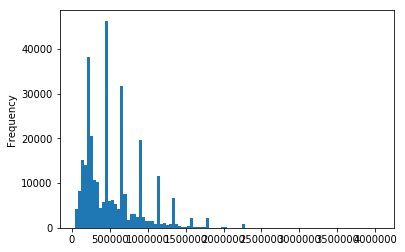

In [100]:
application_train[col_to_analyse].plot.hist(bins=100)

In [101]:
#application_train[col_to_analyse].plot.density()

In [102]:
# Show missing values
application_train[col_to_analyse].isnull().sum()

278

Let´s analyse to which NAME_CONTRACT_TYPE the missing values belong.

In [103]:
application_train[application_train.NAME_CONTRACT_TYPE == 'Revolving loans'][col_to_analyse].isnull().sum()

278

All of the missing values belong to the NAME_CONTRACT_TYPE == 'Revolving loans'.

Now we want to analyse how the missing values could be filled best.

In [104]:
entries_goods_price_same_credit = application_train[(application_train.AMT_GOODS_PRICE.isnull() == False) &
                                                    (application_train.AMT_CREDIT != application_train.AMT_GOODS_PRICE) & 
                                                    (application_train.NAME_CONTRACT_TYPE == "Revolving loans")].shape[0]

entries_goods_price_same_credit / application_train[application_train.NAME_CONTRACT_TYPE == "Revolving loans"].shape[0]

0.011202568393729294

We can see that the only ca. 1% do not have the same AMT_GOODS_PRICE as AMT_CREDIT. This is the reason why we decide to set the missing values for AMT_GOODS_PRICE equal to the AMT_CREDIT. 

In [105]:
indices_with_missing_amt_goods = prep_train[prep_train.AMT_GOODS_PRICE.isnull() == True].index

for index in indices_with_missing_amt_goods:
    prep_train.at[index, col_to_analyse] = prep_train.at[index, "AMT_CREDIT"]

In [106]:
indices_with_missing_amt_goods_test = prep_test[application_test.AMT_GOODS_PRICE.isnull() == True].index

for index in indices_with_missing_amt_goods_test:
    prep_test.at[index, col_to_analyse] = prep_test.at[index, "AMT_CREDIT"]

In [107]:
prep_train[col_to_analyse].isnull().sum()

0

In [108]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.039622856337927566

In [109]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 122)
Shape  TEST: (48744, 121)


### NAME_TYPE_SUITE

Who was accompanying client when he was applying for the loan.

__Different Categories__

In [110]:
col_to_analyse = 'NAME_TYPE_SUITE'

In [111]:
application_train[col_to_analyse].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [112]:
# Values for Class 0
app_train_target_zero = application_train[application_train.TARGET == 0]
app_train_target_zero[col_to_analyse].value_counts()

Unaccompanied      228189
Family              37140
Spouse, partner     10475
Children             3026
Other_B              1596
Other_A               790
Group of people       248
Name: NAME_TYPE_SUITE, dtype: int64

In [113]:
app_train_target_one = application_train[application_train.TARGET == 1]
app_train_target_one[col_to_analyse].value_counts()

Unaccompanied      20337
Family              3009
Spouse, partner      895
Children             241
Other_B              174
Other_A               76
Group of people       23
Name: NAME_TYPE_SUITE, dtype: int64

In [114]:
# We have entries where the NAME_TYPE_SUITE is missing. 
# We decide to fill those missing values with values from entries that are similar regarding
# FLAG_OWN_CAR, CNT_CHILDREN, NAME_FAMILY_STATUS, DAYS_BIRTH and CNT_FAM_MEMBERS.
def handle_missing_values_NAME_TYPE_SUITE(dataset_, threshold_days_birth = 0.05, threshold_cnt_children = 0):
    # to not modify the passed dataset
    dataset = pd.DataFrame.copy(dataset_)
    col_to_analyse = "NAME_TYPE_SUITE" 
    SK_IDS_CURR = dataset[dataset[col_to_analyse].isnull()].SK_ID_CURR.values
    
    for SK_ID_CURR in SK_IDS_CURR:
        # set filter for client with SK_ID_CURR and NAME_TYPE_SUITE == NaN
        NAME_FAMILY_STATUS_FILTER = dataset[dataset.SK_ID_CURR == SK_ID_CURR].NAME_FAMILY_STATUS.iloc[0]
        CNT_CHILDREN_FILTER = dataset[dataset.SK_ID_CURR == SK_ID_CURR].CNT_CHILDREN.iloc[0]
        DAYS_BIRTH_FILTER = dataset[dataset.SK_ID_CURR == SK_ID_CURR].DAYS_BIRTH.iloc[0]

        # get most frequent of those entries that are most simlilar to the one with SK_ID_CURR
        entries_similar = application_train[(application_train[col_to_analyse].isnull() == False)
                                    & (application_train.NAME_FAMILY_STATUS == NAME_FAMILY_STATUS_FILTER) 
                                    & (application_train.CNT_CHILDREN <= (CNT_CHILDREN_FILTER + threshold_cnt_children))
                                    & (application_train.CNT_CHILDREN >= (CNT_CHILDREN_FILTER - threshold_cnt_children))
                                    & (application_train.DAYS_BIRTH >= (DAYS_BIRTH_FILTER*(1+threshold_days_birth)))
                                    & (application_train.DAYS_BIRTH <= (DAYS_BIRTH_FILTER*(1-threshold_days_birth)))].NAME_TYPE_SUITE
        if(entries_similar.size > 0):
            calc_most_freq = entries_similar.describe().top
            # set mean for NAME_TYPE_SUITE in entry with SK_ID_CURR
            IDX_OF_SK_ID_CURR = dataset[dataset.SK_ID_CURR == SK_ID_CURR].index[0]
            dataset.at[IDX_OF_SK_ID_CURR, col_to_analyse] = calc_most_freq 
    return dataset

In [115]:
# Show missing values for train dataset
print("Missing Values for NAME_TYPE_SUITE, application_train: {} prep_train: {}.".format(application_train[col_to_analyse].isnull().sum(),
                                                                                          prep_train[col_to_analyse].isnull().sum()))

Missing Values for NAME_TYPE_SUITE, application_train: 1292 prep_train: 1292.


In [116]:
prep_train = handle_missing_values_NAME_TYPE_SUITE(prep_train)

Now we want to see if there were entries where we could not find a similiar one. 

In [117]:
# Show missing values for train dataset
print("Missing Values for NAME_TYPE_SUITE, application_train: {} prep_train: {}.".format(application_train[col_to_analyse].isnull().sum(),
                                                                                          prep_train[col_to_analyse].isnull().sum()))

Missing Values for NAME_TYPE_SUITE, application_train: 1292 prep_train: 3.


There are stil 3 missing values which could not be filed with the method above. Let´s print them.

In [118]:
prep_train[prep_train[col_to_analyse].isnull()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
41982,148605,0,1,1,0,1,0,450000.0,675000.0,33750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
187348,317181,0,1,0,0,1,0,202500.0,585000.0,29250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
11287,113148,0,1,0,0,1,4,225000.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0


After analysing the three entries with missing values, no concrete "neighbour" with the above used filters were found. At this point we could just delete the three occurencies, instead we decided to fill manually the missing feature with the most frequent. 

In [119]:
IDX_OF_SK_ID_CURR = prep_train[prep_train.SK_ID_CURR == 113148].index[0]
prep_train.at[IDX_OF_SK_ID_CURR, col_to_analyse] = 'Unaccompanied'

IDX_OF_SK_ID_CURR = prep_train[prep_train.SK_ID_CURR == 148605].index[0]
prep_train.at[IDX_OF_SK_ID_CURR, col_to_analyse] = 'Unaccompanied'

IDX_OF_SK_ID_CURR = prep_train[prep_train.SK_ID_CURR == 317181].index[0]
prep_train.at[IDX_OF_SK_ID_CURR, col_to_analyse] = 'Unaccompanied'

In [120]:
prep_train[col_to_analyse].isnull().sum()

0

Now we handle the missing values for the test dataset.

In [121]:
# Show missing values for test dataset
print("Missing Values for NAME_TYPE_SUITE, application_test: {} prep_test: {}.".format(application_test[col_to_analyse].isnull().sum(),
                                                                                        prep_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_TYPE_SUITE, application_test: 911 prep_test: 911.


In [122]:
prep_test = handle_missing_values_NAME_TYPE_SUITE(prep_test)

In [123]:
# Show missing values for test dataset
print("Missing Values for NAME_TYPE_SUITE, application_test: {} prep_test: {}.".format(application_test[col_to_analyse].isnull().sum(),
                                                                                        prep_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_TYPE_SUITE, application_test: 911 prep_test: 0.


Now we want to analyse if th correlation between this feature lableencoded and this feature with only a flag that says if the coustumer was companied or not is different.

In [124]:
le_NAME_TYPE_SUITE = LabelEncoder()
le_NAME_TYPE_SUITE.fit(prep_train[col_to_analyse])

LabelEncoder()

In [125]:
lableencoded_name_type_suite = pd.Series(le_NAME_TYPE_SUITE.transform(prep_train[col_to_analyse]))

In [126]:
prep_train.TARGET.corr(lableencoded_name_type_suite)

0.0035527043575502826

In [127]:
FLAG_NAME_TYPE_SUITE = pd.DataFrame(prep_train[col_to_analyse])
FLAG_NAME_TYPE_SUITE[FLAG_NAME_TYPE_SUITE[col_to_analyse] == 'Unaccompanied'] = 0
FLAG_NAME_TYPE_SUITE[FLAG_NAME_TYPE_SUITE[col_to_analyse] != 0] = 1

In [128]:
prep_train.TARGET.corr(FLAG_NAME_TYPE_SUITE.NAME_TYPE_SUITE)

-0.0073170560293389295

We can see that the correlation is not much different, but a lableencoding means that the different categories get a different weight while training a classifier. So we decide to use a feature with a flag that says if the coustumer was companied or no.

In [129]:
prep_train.loc[prep_train[col_to_analyse] == 'Unaccompanied', col_to_analyse] = 0
prep_train.loc[prep_train[col_to_analyse] != 0, col_to_analyse] = 1

prep_test.loc[prep_test[col_to_analyse] == 'Unaccompanied', col_to_analyse] = 0
prep_test.loc[prep_test[col_to_analyse] != 0, col_to_analyse] = 1

In [130]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0073170560293389295

In [131]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 122)
Shape  TEST: (48744, 121)


### NAME_INCOME_TYPE

Clients income type (businessman, working, maternity leave)

__Different Categories__

In [132]:
col_to_analyse = 'NAME_INCOME_TYPE'

In [133]:
application_train[col_to_analyse].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [134]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()
#app_train_target_zero[col_to_analyse].value_counts()

Working                 143550
Commercial associate     66257
Pensioner                52380
State servant            20454
Student                     18
Unemployed                  14
Businessman                 10
Maternity leave              3
Name: NAME_INCOME_TYPE, dtype: int64

In [135]:
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Working                 15224
Commercial associate     5360
Pensioner                2982
State servant            1249
Unemployed                  8
Maternity leave             2
Name: NAME_INCOME_TYPE, dtype: int64

Show the missing values for train and test data

In [136]:
# Show missing values for test dataset
print("Missing Values for NAME_INCOME_TYPE:\napplication_train: {}\napplication_test: {}"
      .format(application_train[col_to_analyse].isnull().sum(),
              application_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_INCOME_TYPE:
application_train: 0
application_test: 0


In [137]:
one_hot_encoded_NAME_INCOME_TYPE = pd.get_dummies(prep_train.NAME_INCOME_TYPE, prefix=col_to_analyse)

In [138]:
for column in one_hot_encoded_NAME_INCOME_TYPE:
    print("{} corr: {}".format(column,application_train.TARGET.corr(one_hot_encoded_NAME_INCOME_TYPE[column])))

NAME_INCOME_TYPE_Businessman corr: -0.0016899235894631348
NAME_INCOME_TYPE_Commercial associate corr: -0.011899745200012257
NAME_INCOME_TYPE_Maternity leave corr: 0.004725989225510632
NAME_INCOME_TYPE_Pensioner corr: -0.04620705144440399
NAME_INCOME_TYPE_State servant corr: -0.023445349340859595
NAME_INCOME_TYPE_Student corr: -0.002267299907599607
NAME_INCOME_TYPE_Unemployed corr: 0.008784483275365079
NAME_INCOME_TYPE_Working corr: 0.057473913113825784


We decide to add those columns to our dataset and remove the original column NAME_INCOME_TYPE. 

In [139]:
prep_train = pd.concat([prep_train, one_hot_encoded_NAME_INCOME_TYPE], axis=1).drop([col_to_analyse], axis=1)

In [140]:
one_hot_encoded_NAME_INCOME_TYPE_test = pd.get_dummies(prep_test.NAME_INCOME_TYPE, prefix=col_to_analyse)

In [141]:
for column in one_hot_encoded_NAME_INCOME_TYPE_test:
    print("{}".format(column))

NAME_INCOME_TYPE_Businessman
NAME_INCOME_TYPE_Commercial associate
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_State servant
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed
NAME_INCOME_TYPE_Working


We decide to add those columns to our dataset and remove the original column NAME_INCOME_TYPE. 

In [142]:
prep_test = pd.concat([prep_test, one_hot_encoded_NAME_INCOME_TYPE_test], axis=1).drop([col_to_analyse], axis=1)

In [143]:
prep_test["NAME_INCOME_TYPE_Maternity leave"] = 0

In [144]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 129)
Shape  TEST: (48744, 128)


### NAME_EDUCATION_TYPE

Level of highest education the client achieved.

__Different Categories__

In [145]:
col_to_analyse = 'NAME_EDUCATION_TYPE'

In [146]:
application_train[col_to_analyse].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [147]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Secondary / secondary special    198867
Higher education                  70854
Incomplete higher                  9405
Lower secondary                    3399
Academic degree                     161
Name: NAME_EDUCATION_TYPE, dtype: int64

In [148]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Secondary / secondary special    19524
Higher education                  4009
Incomplete higher                  872
Lower secondary                    417
Academic degree                      3
Name: NAME_EDUCATION_TYPE, dtype: int64

Show the missing values for train and test data

In [149]:
# Show missing values for test dataset
print("Missing Values for {}:\napplication_train: {}\napplication_test: {}"
      .format(col_to_analyse, application_train[col_to_analyse].isnull().sum(),
              application_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_EDUCATION_TYPE:
application_train: 0
application_test: 0


In [150]:
one_hot_encoded_NAME_EDUCATION_TYPE = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [151]:
for column in one_hot_encoded_NAME_EDUCATION_TYPE:
    print("{} corr: {}".format(column,application_train.TARGET.corr(one_hot_encoded_NAME_EDUCATION_TYPE[column])))

NAME_EDUCATION_TYPE_Academic degree corr: -0.005294221829046523
NAME_EDUCATION_TYPE_Higher education corr: -0.05658784481831752
NAME_EDUCATION_TYPE_Incomplete higher corr: 0.0028196414947554566
NAME_EDUCATION_TYPE_Lower secondary corr: 0.011747931202088523
NAME_EDUCATION_TYPE_Secondary / secondary special corr: 0.04981638194000645


We decide to add those columns to our dataset and remove the original column NAME_EDUCATION_TYPE. 

In [152]:
prep_train = pd.concat([prep_train, one_hot_encoded_NAME_EDUCATION_TYPE], axis=1).drop([col_to_analyse], axis=1)

Same for Test

In [153]:
one_hot_encoded_NAME_EDUCATION_TYPE_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [154]:
for column in one_hot_encoded_NAME_EDUCATION_TYPE_test:
    print("{}".format(column))

NAME_EDUCATION_TYPE_Academic degree
NAME_EDUCATION_TYPE_Higher education
NAME_EDUCATION_TYPE_Incomplete higher
NAME_EDUCATION_TYPE_Lower secondary
NAME_EDUCATION_TYPE_Secondary / secondary special


We decide to add those columns to our dataset and remove the original column NAME_EDUCATION_TYPE. 

In [155]:
prep_test = pd.concat([prep_test, one_hot_encoded_NAME_EDUCATION_TYPE_test], axis=1).drop([col_to_analyse], axis=1)

In [156]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307506, 133)
Shape  TEST: (48744, 132)


### NAME_FAMILY_STATUS

Family status of the client.

__Different Categories__

In [157]:
col_to_analyse = 'NAME_FAMILY_STATUS'

In [158]:
application_train[col_to_analyse].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [159]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Married                 181582
Single / not married     40987
Civil marriage           26814
Separated                18150
Widow                    15151
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [160]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Married                 14850
Single / not married     4457
Civil marriage           2961
Separated                1620
Widow                     937
Name: NAME_FAMILY_STATUS, dtype: int64

In [161]:
application_train[application_train[col_to_analyse] == 'Unknown'].isnull().sum().sort_values(ascending = False).head(20)

AMT_GOODS_PRICE               2
NAME_TYPE_SUITE               2
OWN_CAR_AGE                   2
CNT_FAM_MEMBERS               2
LANDAREA_MEDI                 2
LANDAREA_AVG                  2
LANDAREA_MODE                 2
AMT_REQ_CREDIT_BUREAU_YEAR    1
LIVINGAPARTMENTS_MODE         1
COMMONAREA_MODE               1
ELEVATORS_MODE                1
ENTRANCES_MODE                1
FLOORSMAX_MODE                1
FLOORSMIN_MODE                1
NONLIVINGAREA_MODE            1
LIVINGAREA_MODE               1
NONLIVINGAPARTMENTS_MODE      1
AMT_REQ_CREDIT_BUREAU_QRT     1
APARTMENTS_MEDI               1
BASEMENTAREA_MEDI             1
dtype: int64

The 2 entries with NAME_FAMILY_STATUS == 'Unknown' seem to have a lot of other missing values. This is why we decide to remove those entries.

In [162]:
index_to_drop_NAME_FAMILY_STATUS = application_train[application_train[col_to_analyse] == 'Unknown'].index

In [163]:
prep_train = prep_train.drop(index_to_drop_NAME_FAMILY_STATUS)

Show the missing values for train and test data

In [164]:
# Show missing values for test dataset
print("Missing Values for {}:\napplication_train: {}\napplication_test: {}"
      .format(col_to_analyse, application_train[col_to_analyse].isnull().sum(),
              application_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_FAMILY_STATUS:
application_train: 0
application_test: 0


In [165]:
one_hot_encoded_NAME_FAMILY_STATUS = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [166]:
for column in one_hot_encoded_NAME_FAMILY_STATUS:
    print("{} corr: {}".format(column,application_train.TARGET.corr(one_hot_encoded_NAME_FAMILY_STATUS[column])))

NAME_FAMILY_STATUS_Civil marriage corr: 0.022502027373722984
NAME_FAMILY_STATUS_Married corr: -0.02505353116242089
NAME_FAMILY_STATUS_Separated corr: 0.0011690334943526535
NAME_FAMILY_STATUS_Single / not married corr: 0.026520910401816793
NAME_FAMILY_STATUS_Widow corr: -0.019393632005744534


We decide to add those columns to our dataset and remove the original column NAME_EDUCATION_TYPE. 

In [167]:
prep_train = pd.concat([prep_train, one_hot_encoded_NAME_FAMILY_STATUS], axis=1).drop([col_to_analyse], axis=1)

In [168]:
one_hot_encoded_NAME_FAMILY_STATUS_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [169]:
for column in one_hot_encoded_NAME_FAMILY_STATUS_test:
    print("{}".format(column))

NAME_FAMILY_STATUS_Civil marriage
NAME_FAMILY_STATUS_Married
NAME_FAMILY_STATUS_Separated
NAME_FAMILY_STATUS_Single / not married
NAME_FAMILY_STATUS_Widow


We decide to add those columns to our dataset and remove the original column NAME_EDUCATION_TYPE. 

In [170]:
prep_test = pd.concat([prep_test, one_hot_encoded_NAME_FAMILY_STATUS_test], axis=1).drop([col_to_analyse], axis=1)

In [171]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 137)
Shape  TEST: (48744, 136)


### NAME_HOUSING_TYPE

What is the housing situation of the client (renting, living with parents, ...).

__Different Categories__

In [172]:
col_to_analyse = 'NAME_HOUSING_TYPE'

In [173]:
application_train[col_to_analyse].value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

In [174]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

House / apartment      251596
With parents            13104
Municipal apartment     10228
Rented apartment         4280
Office apartment         2445
Co-op apartment          1033
Name: NAME_HOUSING_TYPE, dtype: int64

In [175]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

House / apartment      21272
With parents            1736
Municipal apartment      955
Rented apartment         601
Office apartment         172
Co-op apartment           89
Name: NAME_HOUSING_TYPE, dtype: int64

Show the missing values for train and test data

In [176]:
# Show missing values for test dataset
print("Missing Values for {}:\napplication_train: {}\napplication_test: {}"
      .format(col_to_analyse, application_train[col_to_analyse].isnull().sum(),
              application_test[col_to_analyse].isnull().sum()))

Missing Values for NAME_HOUSING_TYPE:
application_train: 0
application_test: 0


In [177]:
one_hot_encoded_NAME_HOUSING_TYPE = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [178]:
for column in one_hot_encoded_NAME_HOUSING_TYPE:
    print("{} corr: {}".format(column,application_train.TARGET.corr(one_hot_encoded_NAME_HOUSING_TYPE[column])))

NAME_HOUSING_TYPE_Co-op apartment corr: -0.00031205881596045425
NAME_HOUSING_TYPE_House / apartment corr: -0.02856415291152673
NAME_HOUSING_TYPE_Municipal apartment corr: 0.0033409263293164002
NAME_HOUSING_TYPE_Office apartment corr: -0.005102539349220174
NAME_HOUSING_TYPE_Rented apartment corr: 0.019768258047419978
NAME_HOUSING_TYPE_With parents corr: 0.02996762352842596


We decide to add those columns to our dataset and remove the original column NAME_HOUSING_TYPE. 

In [179]:
prep_train = pd.concat([prep_train, one_hot_encoded_NAME_HOUSING_TYPE], axis=1).drop([col_to_analyse], axis=1)

In [180]:
one_hot_encoded_NAME_HOUSING_TYPE_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [181]:
for column in one_hot_encoded_NAME_HOUSING_TYPE_test:
    print("{}".format(column))

NAME_HOUSING_TYPE_Co-op apartment
NAME_HOUSING_TYPE_House / apartment
NAME_HOUSING_TYPE_Municipal apartment
NAME_HOUSING_TYPE_Office apartment
NAME_HOUSING_TYPE_Rented apartment
NAME_HOUSING_TYPE_With parents


We decide to add those columns to our dataset and remove the original column NAME_HOUSING_TYPE. 

In [182]:
prep_test = pd.concat([prep_test, one_hot_encoded_NAME_HOUSING_TYPE_test], axis=1).drop([col_to_analyse], axis=1)

In [183]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### REGION_POPULATION_RELATIVE

Normalized population of region where client lives (higher number means the client lives in more populated region).

__numeric value__

In [184]:
col_to_analyse = 'REGION_POPULATION_RELATIVE'

In [185]:
application_train[col_to_analyse].describe()

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

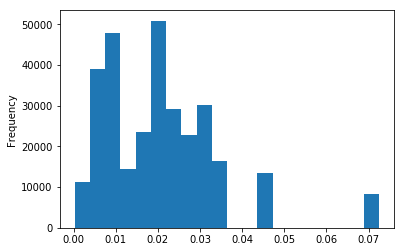

In [186]:
application_train[col_to_analyse].plot.hist(bins=20)

Show the missing values for train and test data

In [187]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for REGION_POPULATION_RELATIVE:
prep_train: 0
prep_test: 0


In [188]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.037217196342622

In [189]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### DAYS_BIRTH

Client's age in days at the time of application.

__numeric value__

In [190]:
col_to_analyse = 'DAYS_BIRTH'

Bevor we plot information about this feature, we want to convert the DAYS_BIRTH to age in years.

In [191]:
prep_train[col_to_analyse] = np.floor(prep_train[col_to_analyse] / -365).astype('int32')

In [192]:
prep_test[col_to_analyse] = np.floor(prep_test[col_to_analyse] / -365).astype('int32')

In [193]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean         43.436147
std          11.954599
min          20.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          69.000000
Name: DAYS_BIRTH, dtype: float64

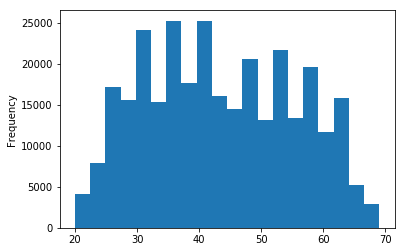

In [194]:
prep_train[col_to_analyse].plot.hist(bins=20)

Show the missing values for train and test data

In [195]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for DAYS_BIRTH:
prep_train: 0
prep_test: 0


In [196]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0782315644899955

In [197]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### DAYS_EMPLOYED

How many days before the application the person started current employment.

__numeric value__

In [198]:
col_to_analyse = 'DAYS_EMPLOYED'

In [199]:
application_train[application_train[col_to_analyse] == 365243].NAME_INCOME_TYPE.value_counts()

Pensioner     55352
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

Bevor we plot information about this feature, we want to convert the days to age in years.

In [200]:
prep_train[col_to_analyse] = np.floor(prep_train[col_to_analyse] / -365).astype('int32')

In [201]:
prep_test[col_to_analyse] = np.floor(prep_test[col_to_analyse] / -365).astype('int32')

In [202]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean       -175.305911
std         386.998704
min       -1001.000000
25%           0.000000
50%           3.000000
75%           7.000000
max          49.000000
Name: DAYS_EMPLOYED, dtype: float64

Now we want to replace the values -1001 with -1 to have lower oscillation.

In [203]:
prep_train.loc[prep_train[col_to_analyse] < 0, col_to_analyse] = -1

In [204]:
prep_test.loc[prep_test[col_to_analyse] < 0, col_to_analyse] = -1

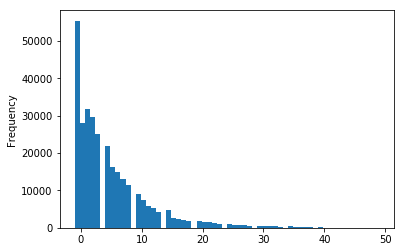

In [205]:
prep_train[col_to_analyse].plot.hist(bins=60)

Show the missing values for train and test data

In [206]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for DAYS_EMPLOYED:
prep_train: 0
prep_test: 0


In [207]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.04395009275792172

In [208]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### DAYS_REGISTRATION

How many days before the application did client change his registration.

__numeric value__

In [209]:
col_to_analyse = 'DAYS_REGISTRATION'

In [210]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean      -4986.142219
std        3522.892090
min      -24672.000000
25%       -7480.000000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [211]:
prep_train[col_to_analyse] = np.floor(prep_train[col_to_analyse] / -365).astype('int32')

In [212]:
prep_test[col_to_analyse] = np.floor(prep_test[col_to_analyse] / -365).astype('int32')

In [213]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean         13.168743
std           9.646858
min           0.000000
25%           5.000000
50%          12.000000
75%          20.000000
max          67.000000
Name: DAYS_REGISTRATION, dtype: float64

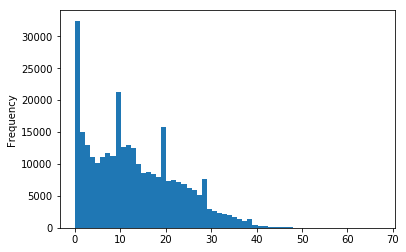

In [214]:
prep_train[col_to_analyse].plot.hist(bins=60)

Show the missing values for train and test data

In [215]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for DAYS_REGISTRATION:
prep_train: 0
prep_test: 0


In [216]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.041984399148372396

In [217]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### DAYS_ID_PUBLISH

How many days before the application did client change the identity document with which he applied for the loan.

__numeric value__

In [218]:
col_to_analyse = 'DAYS_ID_PUBLISH'

In [219]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean      -2994.199327
std        1509.456887
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

In [220]:
prep_train[col_to_analyse] = np.floor(prep_train[col_to_analyse] / -365).astype('int32')

In [221]:
prep_test[col_to_analyse] = np.floor(prep_test[col_to_analyse] / -365).astype('int32')

In [222]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          7.713467
std           4.134534
min           0.000000
25%           4.000000
50%           8.000000
75%          11.000000
max          19.000000
Name: DAYS_ID_PUBLISH, dtype: float64

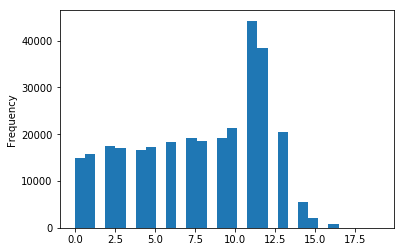

In [223]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [224]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for DAYS_ID_PUBLISH:
prep_train: 0
prep_test: 0


In [225]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.05112847514106122

In [226]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### OWN_CAR_AGE

Age of client's car.

__numeric value__

In [227]:
col_to_analyse = 'OWN_CAR_AGE'

In [228]:
prep_train[col_to_analyse].describe()

count    104580.000000
mean         12.061121
std          11.944919
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

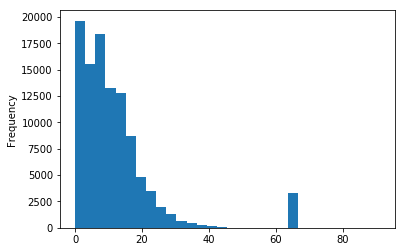

In [229]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [230]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for OWN_CAR_AGE:
prep_train: 202924
prep_test: 32312


In [231]:
prep_train.loc[prep_train[col_to_analyse].isnull(), col_to_analyse] = -1

In [232]:
prep_test.loc[prep_test[col_to_analyse].isnull(), col_to_analyse] = -1

In [233]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.0011042416017870565

In [234]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_MOBIL

Did client provide mobile phone (1=YES, 0=NO).

__numeric value__

In [235]:
col_to_analyse = 'FLAG_MOBIL'

In [236]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.999997
std           0.001803
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_MOBIL, dtype: float64

In [237]:
prep_train[col_to_analyse].value_counts()

1    307503
0         1
Name: FLAG_MOBIL, dtype: int64

Show the missing values for train and test data

In [238]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_MOBIL:
prep_train: 0
prep_test: 0


In [239]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.0005343965693041863

In [240]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_EMP_PHONE

Did client provide work phone (1=YES, 0=NO).

__numeric value__

In [241]:
col_to_analyse = 'FLAG_EMP_PHONE'

In [242]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.819885
std           0.384284
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_EMP_PHONE, dtype: float64

In [243]:
prep_train[col_to_analyse].value_counts()

1    252118
0     55386
Name: FLAG_EMP_PHONE, dtype: int64

Show the missing values for train and test data

In [244]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_EMP_PHONE:
prep_train: 0
prep_test: 0


In [245]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.04598079213679263

In [246]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_WORK_PHONE

Did client provide work phone (1=YES, 0=NO).

__numeric value__

In [247]:
col_to_analyse = 'FLAG_WORK_PHONE'

In [248]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.199357
std           0.399517
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_WORK_PHONE, dtype: float64

In [249]:
prep_train[col_to_analyse].value_counts()

0    246201
1     61303
Name: FLAG_WORK_PHONE, dtype: int64

Show the missing values for train and test data

In [250]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_WORK_PHONE:
prep_train: 0
prep_test: 0


In [251]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.02854048089480389

In [252]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_CONT_MOBILE

Was mobile phone reachable (1=YES, 0=NO).

__numeric value__

In [253]:
col_to_analyse = 'FLAG_CONT_MOBILE'

In [254]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.998133
std           0.043164
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_CONT_MOBILE, dtype: float64

In [255]:
prep_train[col_to_analyse].value_counts()

1    306930
0       574
Name: FLAG_CONT_MOBILE, dtype: int64

Show the missing values for train and test data

In [256]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_CONT_MOBILE:
prep_train: 0
prep_test: 0


In [257]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.0003699094679478691

In [258]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_PHONE

Did client provide home phone (1=YES, 0=NO).

__numeric value__

In [259]:
col_to_analyse = 'FLAG_PHONE'

In [260]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.281057
std           0.449516
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: FLAG_PHONE, dtype: float64

In [261]:
prep_train[col_to_analyse].value_counts()

0    221078
1     86426
Name: FLAG_PHONE, dtype: int64

Show the missing values for train and test data

In [262]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_PHONE:
prep_train: 0
prep_test: 0


In [263]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0237932934131653

In [264]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### FLAG_EMAIL

Did client provide email (1=YES, 0=NO).

__numeric value__

In [265]:
col_to_analyse = 'FLAG_EMAIL'

In [266]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          0.056721
std           0.231310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_EMAIL, dtype: float64

In [267]:
prep_train[col_to_analyse].value_counts()

0    290062
1     17442
Name: FLAG_EMAIL, dtype: int64

Show the missing values for train and test data

In [268]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for FLAG_EMAIL:
prep_train: 0
prep_test: 0


In [269]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.0017571456149743673

In [270]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 142)
Shape  TEST: (48744, 141)


### OCCUPATION_TYPE

What kind of occupation does the client have.

__Different Categories__

In [271]:
col_to_analyse = 'OCCUPATION_TYPE'

In [272]:
application_train[col_to_analyse].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [273]:
# Values for Class 0
application_train[application_train.TARGET == 0][col_to_analyse].value_counts()

Laborers                 49348
Sales staff              29010
Core staff               25832
Managers                 20043
Drivers                  16496
High skill tech staff    10679
Accountants               9339
Medicine staff            7965
Security staff            5999
Cooking staff             5325
Cleaning staff            4206
Private service staff     2477
Low-skill Laborers        1734
Secretaries               1213
Waiters/barmen staff      1196
Realty agents              692
HR staff                   527
IT staff                   492
Name: OCCUPATION_TYPE, dtype: int64

In [274]:
# Values for Class 1
application_train[application_train.TARGET == 1][col_to_analyse].value_counts()

Laborers                 5838
Sales staff              3092
Drivers                  2107
Core staff               1738
Managers                 1328
Security staff            722
High skill tech staff     701
Cooking staff             621
Medicine staff            572
Accountants               474
Cleaning staff            447
Low-skill Laborers        359
Private service staff     175
Waiters/barmen staff      152
Secretaries                92
Realty agents              59
HR staff                   36
IT staff                   34
Name: OCCUPATION_TYPE, dtype: int64

Show the missing values for train and test data

In [275]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for OCCUPATION_TYPE:
prep_train: 96389
prep_test: 15605


In [276]:
one_hot_encoded_OCCUPATION_TYPE = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse, dummy_na = True)

In [277]:
for column in one_hot_encoded_OCCUPATION_TYPE:
    print("{} corr: {}".format(column, prep_train.TARGET.corr(one_hot_encoded_OCCUPATION_TYPE[column])))

OCCUPATION_TYPE_Accountants corr: -0.02160553263765021
OCCUPATION_TYPE_Cleaning staff corr: 0.0069796680892837614
OCCUPATION_TYPE_Cooking staff corr: 0.012222856513430101
OCCUPATION_TYPE_Core staff corr: -0.020373640077792448
OCCUPATION_TYPE_Drivers corr: 0.03030542658509146
OCCUPATION_TYPE_HR staff corr: -0.0026387355305109044
OCCUPATION_TYPE_High skill tech staff corr: -0.013764920045706631
OCCUPATION_TYPE_IT staff corr: -0.0024446992440291223
OCCUPATION_TYPE_Laborers corr: 0.0429940305720526
OCCUPATION_TYPE_Low-skill Laborers corr: 0.027610057320108367
OCCUPATION_TYPE_Managers corr: -0.018643569564306482
OCCUPATION_TYPE_Medicine staff corr: -0.008513712547085798
OCCUPATION_TYPE_Private service staff corr: -0.005046514148461772
OCCUPATION_TYPE_Realty agents corr: -0.00039332235693145253
OCCUPATION_TYPE_Sales staff corr: 0.019539441855228788
OCCUPATION_TYPE_Secretaries corr: -0.0024514188471093535
OCCUPATION_TYPE_Security staff corr: 0.014649456050558729
OCCUPATION_TYPE_Waiters/barmen

We decide to add those columns to our dataset and remove the original column OCCUPATION_TYPE. 

In [278]:
prep_train = pd.concat([prep_train, one_hot_encoded_OCCUPATION_TYPE], axis=1).drop([col_to_analyse], axis=1)

In [279]:
one_hot_encoded_OCCUPATION_TYPE_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse, dummy_na = True)

In [280]:
for column in one_hot_encoded_OCCUPATION_TYPE_test:
    print("{}".format(column))

OCCUPATION_TYPE_Accountants
OCCUPATION_TYPE_Cleaning staff
OCCUPATION_TYPE_Cooking staff
OCCUPATION_TYPE_Core staff
OCCUPATION_TYPE_Drivers
OCCUPATION_TYPE_HR staff
OCCUPATION_TYPE_High skill tech staff
OCCUPATION_TYPE_IT staff
OCCUPATION_TYPE_Laborers
OCCUPATION_TYPE_Low-skill Laborers
OCCUPATION_TYPE_Managers
OCCUPATION_TYPE_Medicine staff
OCCUPATION_TYPE_Private service staff
OCCUPATION_TYPE_Realty agents
OCCUPATION_TYPE_Sales staff
OCCUPATION_TYPE_Secretaries
OCCUPATION_TYPE_Security staff
OCCUPATION_TYPE_Waiters/barmen staff
OCCUPATION_TYPE_nan


We decide to add those columns to our dataset and remove the original column OCCUPATION_TYPE. 

In [281]:
prep_test = pd.concat([prep_test, one_hot_encoded_OCCUPATION_TYPE_test], axis=1).drop([col_to_analyse], axis=1)

In [282]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 160)
Shape  TEST: (48744, 159)


### CNT_FAM_MEMBERS

How many family members does client have.

__numeric value__

In [283]:
col_to_analyse = 'CNT_FAM_MEMBERS'

In [284]:
prep_train[col_to_analyse].describe()

count    307504.000000
mean          2.152655
std           0.910680
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

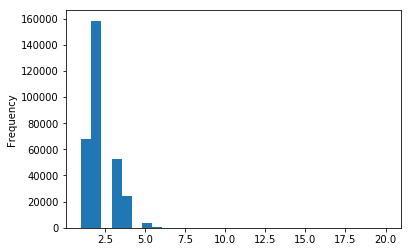

In [285]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [286]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for CNT_FAM_MEMBERS:
prep_train: 0
prep_test: 0


In [287]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.009300369225758661

In [288]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 160)
Shape  TEST: (48744, 159)


### REGION_RATING_CLIENT

Our rating of the region where client lives (1,2,3).

__numeric value__

In [289]:
col_to_analyse = 'REGION_RATING_CLIENT'

In [290]:
prep_train[col_to_analyse].value_counts()

2    226978
3     48329
1     32197
Name: REGION_RATING_CLIENT, dtype: int64

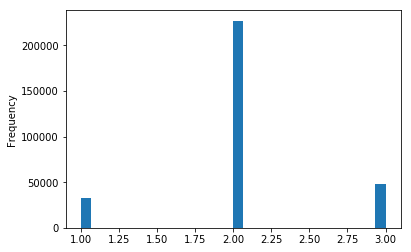

In [291]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [292]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for REGION_RATING_CLIENT:
prep_train: 0
prep_test: 0


In [293]:
one_hot_encoded_REGION_RATING_CLIENT = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [294]:
for column in one_hot_encoded_REGION_RATING_CLIENT:
    print("{} corr: {}".format(column, application_train.TARGET.corr(one_hot_encoded_REGION_RATING_CLIENT[column])))

REGION_RATING_CLIENT_1 corr: -0.04082934987658307
REGION_RATING_CLIENT_2 corr: -0.011331896147840142
REGION_RATING_CLIENT_3 corr: 0.0480356584500622


We decide to add those columns to our dataset and remove the original column REGION_RATING_CLIENT. 

In [295]:
prep_train = pd.concat([prep_train, one_hot_encoded_REGION_RATING_CLIENT], axis=1).drop([col_to_analyse], axis=1)

In [296]:
one_hot_encoded_REGION_RATING_CLIENT_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [297]:
for column in one_hot_encoded_REGION_RATING_CLIENT_test:
    print("{}".format(column))

REGION_RATING_CLIENT_1
REGION_RATING_CLIENT_2
REGION_RATING_CLIENT_3


We decide to add those columns to our dataset and remove the original column REGION_RATING_CLIENT. 

In [298]:
prep_test = pd.concat([prep_test, one_hot_encoded_REGION_RATING_CLIENT_test], axis=1).drop([col_to_analyse], axis=1)

In [299]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 162)
Shape  TEST: (48744, 161)


### REGION_RATING_CLIENT_W_CITY

Our rating of the region where client lives with taking city into account (1,2,3).

__numeric value__

In [300]:
col_to_analyse = 'REGION_RATING_CLIENT_W_CITY'

In [301]:
prep_train[col_to_analyse].value_counts()

2    229478
3     43859
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

Show the missing values for train and test data

In [302]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for REGION_RATING_CLIENT_W_CITY:
prep_train: 0
prep_test: 0


In [303]:
one_hot_encoded_REGION_RATING_CLIENT_W_CITY = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [304]:
for column in one_hot_encoded_REGION_RATING_CLIENT_W_CITY:
    print("{} corr: {}".format(column, prep_train.TARGET.corr(one_hot_encoded_REGION_RATING_CLIENT_W_CITY[column])))

REGION_RATING_CLIENT_W_CITY_1 corr: -0.04194378961694845
REGION_RATING_CLIENT_W_CITY_2 corr: -0.009770719329539325
REGION_RATING_CLIENT_W_CITY_3 corr: 0.04985320922054096


We decide to add those columns to our dataset and remove the original column REGION_RATING_CLIENT_W_CITY. 

In [305]:
prep_train = pd.concat([prep_train, one_hot_encoded_REGION_RATING_CLIENT_W_CITY], axis=1).drop([col_to_analyse], axis=1)

In [306]:
one_hot_encoded_REGION_RATING_CLIENT_W_CITY_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [307]:
for column in one_hot_encoded_REGION_RATING_CLIENT_W_CITY_test:
    print("{}".format(column))

REGION_RATING_CLIENT_W_CITY_-1
REGION_RATING_CLIENT_W_CITY_1
REGION_RATING_CLIENT_W_CITY_2
REGION_RATING_CLIENT_W_CITY_3


In [308]:
prep_test[prep_test[col_to_analyse] == -1]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,REGION_RATING_CLIENT_1,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3
17177,224393,0,0,0,0,0,270000.0,385164.0,16321.5,292500.0,...,0,0,0,0,0,0,0,0,1,0


We have one entry in the test data which has a value of -1. This probably means the information was not given. We decide to encode the unknown value as zero for the other columns.  

In [309]:
one_hot_encoded_REGION_RATING_CLIENT_W_CITY_test.drop("REGION_RATING_CLIENT_W_CITY_-1", axis=1, inplace = True)

In [310]:
prep_test = pd.concat([prep_test, one_hot_encoded_REGION_RATING_CLIENT_W_CITY_test], axis=1).drop([col_to_analyse], axis=1)

In [311]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 164)
Shape  TEST: (48744, 163)


### WEEKDAY_APPR_PROCESS_START

On which day of the week did the client apply for the loan.

__categorical values__

In [312]:
col_to_analyse = 'WEEKDAY_APPR_PROCESS_START'

In [313]:
prep_train[col_to_analyse].value_counts()

TUESDAY      53899
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50589
FRIDAY       50335
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

Show the missing values for train and test data

In [314]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for WEEKDAY_APPR_PROCESS_START:
prep_train: 0
prep_test: 0


In [315]:
one_hot_encoded_WEEKDAY_APPR_PROCESS_START = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [316]:
for column in one_hot_encoded_WEEKDAY_APPR_PROCESS_START:
    print("{} corr: {}".format(column, application_train.TARGET.corr(one_hot_encoded_WEEKDAY_APPR_PROCESS_START[column])))

WEEKDAY_APPR_PROCESS_START_FRIDAY corr: 0.0012126900457715983
WEEKDAY_APPR_PROCESS_START_MONDAY corr: -0.005147074683283934
WEEKDAY_APPR_PROCESS_START_SATURDAY corr: -0.00239455974923191
WEEKDAY_APPR_PROCESS_START_SUNDAY corr: -0.0012430909682605838
WEEKDAY_APPR_PROCESS_START_THURSDAY corr: 0.0004534060516787676
WEEKDAY_APPR_PROCESS_START_TUESDAY corr: 0.004674290981758656
WEEKDAY_APPR_PROCESS_START_WEDNESDAY corr: 0.001449859703374999


We want to see how a seperation in week and weekend corralates with the target. 

In [317]:
new_week_col = prep_train.copy()
new_week_col.loc[(prep_train[col_to_analyse] != "SATURDAY") & (prep_train[col_to_analyse] != "SUNDAY"), col_to_analyse] = 1

In [318]:
new_week_col.loc[(prep_train[col_to_analyse] == "SATURDAY") | (prep_train[col_to_analyse] == "SUNDAY"), col_to_analyse] = 0

In [319]:
new_week_col.TARGET.corr(new_week_col[col_to_analyse])

0.0027825716589323733

There's really a very low correlation for this feature. There's also no logical reason for this feature to have some importance on the TARGET. Since we have already a very high amount of features (even without taking the other files in count) we decided to just ad-hoc remove this feautre for now. We should analyse later if it haves any negative effect on the score.

In [320]:
# Use this line to add the new feature
# prep_train = pd.concat([prep_train, one_hot_encoded_WEEKDAY_APPR_PROCESS_START], axis=1).drop([col_to_analyse], axis=1)

In [321]:
# drop column
prep_train.drop(columns=[col_to_analyse], inplace=True)
prep_test.drop(columns=[col_to_analyse], inplace=True)

In [322]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 163)
Shape  TEST: (48744, 162)


### HOUR_APPR_PROCESS_START

Approximately at what hour did the client apply for the loan

In [323]:
col_to_analyse = 'HOUR_APPR_PROCESS_START'

Show the missing values for train and test data

In [324]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for HOUR_APPR_PROCESS_START:
prep_train: 0
prep_test: 0


We take basically the same argumentation as above to drop this feature

In [325]:
prep_train.drop(columns=[col_to_analyse], inplace=True)
prep_test.drop(columns=[col_to_analyse], inplace=True)

In [326]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 162)
Shape  TEST: (48744, 161)


### Flags - REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_LIVE_REGION ,REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)

In [327]:
col_to_analyse = ['REG_REGION_NOT_LIVE_REGION',
                  'REG_REGION_NOT_WORK_REGION',
                  'LIVE_REGION_NOT_WORK_REGION',
                  'REG_CITY_NOT_LIVE_CITY',
                  'REG_CITY_NOT_WORK_CITY',
                  'LIVE_CITY_NOT_WORK_CITY']

In [328]:
# show present values of features
for col in col_to_analyse:
    print("{}".format(col))
    print("{}".format(prep_train[col].value_counts()))
    print("------------------------------")

REG_REGION_NOT_LIVE_REGION
0    302847
1      4657
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64
------------------------------
REG_REGION_NOT_WORK_REGION
0    291893
1     15611
Name: REG_REGION_NOT_WORK_REGION, dtype: int64
------------------------------
LIVE_REGION_NOT_WORK_REGION
0    295002
1     12502
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64
------------------------------
REG_CITY_NOT_LIVE_CITY
0    283465
1     24039
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64
------------------------------
REG_CITY_NOT_WORK_CITY
0    236638
1     70866
Name: REG_CITY_NOT_WORK_CITY, dtype: int64
------------------------------
LIVE_CITY_NOT_WORK_CITY
0    252290
1     55214
Name: LIVE_CITY_NOT_WORK_CITY, dtype: int64
------------------------------


All columns are binary!

Show the missing values for train and test data

In [329]:
# Show missing values for test dataset
for col in col_to_analyse:
    print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
          .format(col, prep_train[col].isnull().sum(),
                  prep_test[col].isnull().sum()))
    print("------------------------------")

Missing Values for REG_REGION_NOT_LIVE_REGION:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for REG_REGION_NOT_WORK_REGION:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for LIVE_REGION_NOT_WORK_REGION:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for REG_CITY_NOT_LIVE_CITY:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for REG_CITY_NOT_WORK_CITY:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for LIVE_CITY_NOT_WORK_CITY:
prep_train: 0
prep_test: 0
------------------------------


No missing values for the feature. No work needed fo this features.

In [330]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 162)
Shape  TEST: (48744, 161)


### ORGANIZATION_TYPE

Type of organization where client works

In [331]:
col_to_analyse = 'ORGANIZATION_TYPE'

Show the missing values for train and test data.

In [332]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for ORGANIZATION_TYPE:
prep_train: 0
prep_test: 0


In [333]:
prep_train[col_to_analyse].value_counts()

Business Entity Type 3    67991
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [334]:
prep_train[col_to_analyse].value_counts().shape

(58,)

There's a lot of categories for this feature (total of 58). We can see that a category is represented by various types. We could do one-hot-enconding, but this would add a lot of dimensions to our data... So first let's see what the correlation of each category is.

In [335]:
one_hot_encoded_ORGANIZATION_TYPE = pd.get_dummies(prep_train[col_to_analyse], prefix=col_to_analyse)

In [336]:
for column in one_hot_encoded_ORGANIZATION_TYPE:
    print("{} corr: {}".format(column, application_train.TARGET.corr(one_hot_encoded_ORGANIZATION_TYPE[column])))

ORGANIZATION_TYPE_Advertising corr: 0.00011767852856641196
ORGANIZATION_TYPE_Agriculture corr: 0.007901737416163975
ORGANIZATION_TYPE_Bank corr: -0.009609097579105127
ORGANIZATION_TYPE_Business Entity Type 1 corr: 0.000346393486475668
ORGANIZATION_TYPE_Business Entity Type 2 corr: 0.003158516636295332
ORGANIZATION_TYPE_Business Entity Type 3 corr: 0.023969511463521345
ORGANIZATION_TYPE_Cleaning corr: 0.003290174287291313
ORGANIZATION_TYPE_Construction corr: 0.019793021912756066
ORGANIZATION_TYPE_Culture corr: -0.003264872384943765
ORGANIZATION_TYPE_Electricity corr: -0.002945020542505442
ORGANIZATION_TYPE_Emergency corr: -0.0014580092155974974
ORGANIZATION_TYPE_Government corr: -0.00751957894920703
ORGANIZATION_TYPE_Hotel corr: -0.003409463524954041
ORGANIZATION_TYPE_Housing corr: -0.0004637369639769764
ORGANIZATION_TYPE_Industry: type 1 corr: 0.006402766915092236
ORGANIZATION_TYPE_Industry: type 10 corr: -0.0011410539533094719
ORGANIZATION_TYPE_Industry: type 11 corr: 0.00200917745913

In [337]:
prep_train = pd.concat([prep_train, one_hot_encoded_ORGANIZATION_TYPE], axis=1).drop([col_to_analyse], axis=1)

In [338]:
one_hot_encoded_ORGANIZATION_TYPE_test = pd.get_dummies(prep_test[col_to_analyse], prefix=col_to_analyse)

In [339]:
for column in one_hot_encoded_ORGANIZATION_TYPE_test:
    print("{}".format(column))

ORGANIZATION_TYPE_Advertising
ORGANIZATION_TYPE_Agriculture
ORGANIZATION_TYPE_Bank
ORGANIZATION_TYPE_Business Entity Type 1
ORGANIZATION_TYPE_Business Entity Type 2
ORGANIZATION_TYPE_Business Entity Type 3
ORGANIZATION_TYPE_Cleaning
ORGANIZATION_TYPE_Construction
ORGANIZATION_TYPE_Culture
ORGANIZATION_TYPE_Electricity
ORGANIZATION_TYPE_Emergency
ORGANIZATION_TYPE_Government
ORGANIZATION_TYPE_Hotel
ORGANIZATION_TYPE_Housing
ORGANIZATION_TYPE_Industry: type 1
ORGANIZATION_TYPE_Industry: type 10
ORGANIZATION_TYPE_Industry: type 11
ORGANIZATION_TYPE_Industry: type 12
ORGANIZATION_TYPE_Industry: type 13
ORGANIZATION_TYPE_Industry: type 2
ORGANIZATION_TYPE_Industry: type 3
ORGANIZATION_TYPE_Industry: type 4
ORGANIZATION_TYPE_Industry: type 5
ORGANIZATION_TYPE_Industry: type 6
ORGANIZATION_TYPE_Industry: type 7
ORGANIZATION_TYPE_Industry: type 8
ORGANIZATION_TYPE_Industry: type 9
ORGANIZATION_TYPE_Insurance
ORGANIZATION_TYPE_Kindergarten
ORGANIZATION_TYPE_Legal Services
ORGANIZATION_TYPE_Medi

In [340]:
prep_test = pd.concat([prep_test, one_hot_encoded_ORGANIZATION_TYPE_test], axis=1).drop([col_to_analyse], axis=1)

In [341]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 219)
Shape  TEST: (48744, 218)


### EXT_SOURCE_1

Normalized score from external data source.

__numeric value__

In [342]:
col_to_analyse = 'EXT_SOURCE_1'

In [343]:
prep_train[col_to_analyse].describe()

count    134129.000000
mean          0.502129
std           0.211065
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675062
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

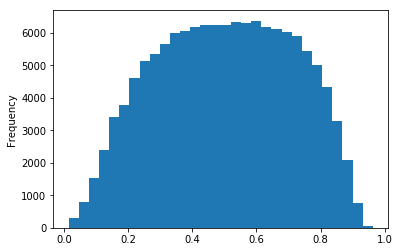

In [344]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [345]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for EXT_SOURCE_1:
prep_train: 173375
prep_test: 20532


In [346]:
(prep_train[col_to_analyse].isnull().sum() / prep_train.shape[0]) * 100

56.38138040480774

There are around 56.4% missing values for this column, This is why we want to try different methods to fill the missing values and evaluate the change of the correlation with the TARGET.

In [347]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.1553181218111595

In [348]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='most_frequent')
imp.fit(prep_train[[col_to_analyse]])

Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)

In [349]:
test_corr_most_frequent = imp.transform(prep_train[[col_to_analyse]]).ravel()
prep_train.TARGET.corr(pd.Series(test_corr_most_frequent))

0.0012469103888293424

In [350]:
imp = Imputer(strategy='median')
imp.fit(prep_train[[col_to_analyse]])

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [351]:
test_corr_median = imp.transform(prep_train[[col_to_analyse]]).ravel()
prep_train.TARGET.corr(pd.Series(test_corr_median))

0.0018194919375920744

In [352]:
imp = Imputer(strategy='mean')
imp.fit(prep_train[[col_to_analyse]])

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [353]:
test_corr_mean = imp.transform(prep_train[[col_to_analyse]]).ravel()
prep_train.TARGET.corr(pd.Series(test_corr_mean))

0.0018089368111360732

In [354]:
#corr = prep_train.corr()

In [355]:
#corr.EXT_SOURCE_1.sort_values()

In [356]:
from sklearn.linear_model import LinearRegression

columns_NN_EXT_1 = ["DAYS_BIRTH", "NAME_INCOME_TYPE_Pensioner", "CODE_GENDER", "FLAG_EMP_PHONE"] 
lreg = LinearRegression()
lreg.fit(pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), columns_NN_EXT_1]), 
         pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), col_to_analyse]))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [357]:
prep_train.loc[prep_train[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].isnull(), columns_NN_EXT_1]))

In [358]:
prep_test.loc[prep_test[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_test.loc[prep_test[col_to_analyse].isnull(), columns_NN_EXT_1]))

In [359]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for EXT_SOURCE_1:
prep_train: 0
prep_test: 0


In [360]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.12421651796050107

In [361]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 219)
Shape  TEST: (48744, 218)


### EXT_SOURCE_2

Normalized score from external data source.

__numeric value__

In [362]:
col_to_analyse = 'EXT_SOURCE_2'

In [363]:
prep_train[col_to_analyse].describe()

count    3.068440e+05
mean     5.143921e-01
std      1.910594e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659587e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64

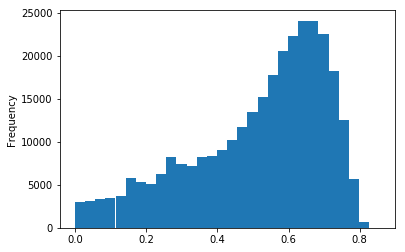

In [364]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [365]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for EXT_SOURCE_2:
prep_train: 660
prep_test: 8


In [366]:
(prep_train[col_to_analyse].isnull().sum() / prep_train.shape[0]) * 100

0.214631354388886

There are around 21.5% missing values for this column, This is why we want to try different methods to fill the missing values and evaluate the change of the correlation with the TARGET.

In [367]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.1604511850262858

In [368]:
#corr = prep_train.corr()

In [369]:
#corr.EXT_SOURCE_2.sort_values()

In [370]:
from sklearn.linear_model import LinearRegression

columns_NN_EXT_2 = ["REGION_RATING_CLIENT_1", "REGION_RATING_CLIENT_W_CITY_1",
                    "REGION_RATING_CLIENT_3", "REGION_RATING_CLIENT_W_CITY_3"] 
lreg = LinearRegression()
lreg.fit(pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), columns_NN_EXT_2]), 
         pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), col_to_analyse]))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [371]:
prep_train.loc[prep_train[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].isnull(), columns_NN_EXT_2]))

In [372]:
prep_test.loc[prep_test[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_test.loc[prep_test[col_to_analyse].isnull(), columns_NN_EXT_2]))

In [373]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for EXT_SOURCE_2:
prep_train: 0
prep_test: 0


In [374]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.16028865931721203

In [375]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 219)
Shape  TEST: (48744, 218)


### EXT_SOURCE_3

Normalized score from external data source.

__numeric value__

In [376]:
col_to_analyse = 'EXT_SOURCE_3'

In [377]:
prep_train[col_to_analyse].describe()

count    246540.000000
mean          0.510857
std           0.194842
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

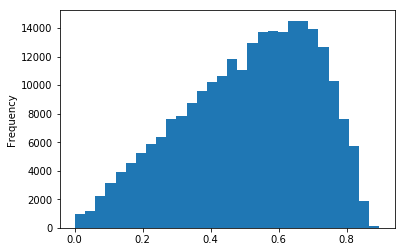

In [378]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [379]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for EXT_SOURCE_3:
prep_train: 60964
prep_test: 8668


In [380]:
(prep_train[col_to_analyse].isnull().sum() / prep_train.shape[0]) * 100

19.82543316509704

There are around 19.8% missing values for this column, This is why we want to try different methods to fill the missing values and evaluate the change of the correlation with the TARGET.

In [381]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.1789049621739273

In [382]:
from sklearn.linear_model import LinearRegression

columns_NN_EXT_2 = ["FLAG_EMP_PHONE", "REG_CITY_NOT_WORK_CITY",
                    "DAYS_BIRTH", "EXT_SOURCE_1"] 
lreg = LinearRegression()
lreg.fit(pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), columns_NN_EXT_2]), 
         pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].notnull(), col_to_analyse]))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [383]:
prep_train.loc[prep_train[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_train.loc[prep_train[col_to_analyse].isnull(), columns_NN_EXT_2]))

In [384]:
prep_test.loc[prep_test[col_to_analyse].isnull(), col_to_analyse] = lreg.predict(
    pd.DataFrame(prep_test.loc[prep_test[col_to_analyse].isnull(), columns_NN_EXT_2]))

In [385]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

-0.1618849723774291

In [386]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 219)
Shape  TEST: (48744, 218)


### DAYS_LAST_PHONE_CHANGE

__numeric value__

In [387]:
col_to_analyse = 'DAYS_LAST_PHONE_CHANGE'

In [388]:
prep_train[col_to_analyse].describe()

count    307503.000000
mean       -962.864964
std         826.813498
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

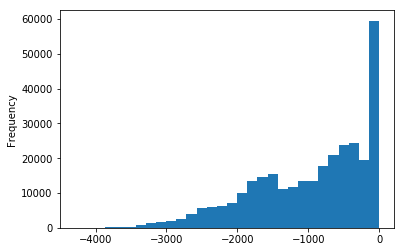

In [389]:
prep_train[col_to_analyse].plot.hist(bins=30)

Show the missing values for train and test data

In [390]:
# Show missing values for test dataset
print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
      .format(col_to_analyse, prep_train[col_to_analyse].isnull().sum(),
              prep_test[col_to_analyse].isnull().sum()))

Missing Values for DAYS_LAST_PHONE_CHANGE:
prep_train: 1
prep_test: 0


In [391]:
prep_train.TARGET.corr(prep_train[col_to_analyse])

0.05520815859566069

In [392]:
imp_DAYS_LAST_PHONE_CHANGE = Imputer(strategy='mean')
imp_DAYS_LAST_PHONE_CHANGE.fit(np.array(prep_train.DAYS_LAST_PHONE_CHANGE).reshape(-1,1))

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [393]:
prep_train.DAYS_LAST_PHONE_CHANGE = imp_DAYS_LAST_PHONE_CHANGE.transform(np.array(prep_train.DAYS_LAST_PHONE_CHANGE).reshape(-1,1))
prep_test.DAYS_LAST_PHONE_CHANGE = imp_DAYS_LAST_PHONE_CHANGE.transform(np.array(prep_test.DAYS_LAST_PHONE_CHANGE).reshape(-1,1))

### Flags - FLAG_DOCUMENT_X

Did client provide document X.

In [394]:
col_to_analyse = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 
                  'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
                  'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
                  'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

In [395]:
# show present values of features
for col in col_to_analyse:
    print("{}".format(col))
    print("{}".format(prep_train[col].value_counts()))
    print("------------------------------")

FLAG_DOCUMENT_2
0    307491
1        13
Name: FLAG_DOCUMENT_2, dtype: int64
------------------------------
FLAG_DOCUMENT_3
1    218339
0     89165
Name: FLAG_DOCUMENT_3, dtype: int64
------------------------------
FLAG_DOCUMENT_4
0    307479
1        25
Name: FLAG_DOCUMENT_4, dtype: int64
------------------------------
FLAG_DOCUMENT_5
0    302857
1      4647
Name: FLAG_DOCUMENT_5, dtype: int64
------------------------------
FLAG_DOCUMENT_6
0    280426
1     27078
Name: FLAG_DOCUMENT_6, dtype: int64
------------------------------
FLAG_DOCUMENT_7
0    307446
1        58
Name: FLAG_DOCUMENT_7, dtype: int64
------------------------------
FLAG_DOCUMENT_8
0    282480
1     25024
Name: FLAG_DOCUMENT_8, dtype: int64
------------------------------
FLAG_DOCUMENT_9
0    306306
1      1198
Name: FLAG_DOCUMENT_9, dtype: int64
------------------------------
FLAG_DOCUMENT_10
0    307497
1         7
Name: FLAG_DOCUMENT_10, dtype: int64
------------------------------
FLAG_DOCUMENT_11
0    306301
1     

All columns are binary!

Show the missing values for train and test data

In [396]:
# Show missing values for test dataset
for col in col_to_analyse:
    print("Missing Values for {}:\nprep_train: {}\nprep_test: {}"
          .format(col, prep_train[col].isnull().sum(),
                  prep_test[col].isnull().sum()))
    print("------------------------------")

Missing Values for FLAG_DOCUMENT_2:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_3:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_4:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_5:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_6:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_7:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_8:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_9:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_10:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_11:
prep_train: 0
prep_test: 0
------------------------------
Missing Values for FLAG_DOCUMENT_12:
prep_train: 0
prep_te

In [397]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 219)
Shape  TEST: (48744, 218)


### Delete non used columns 

In [398]:
cols_to_delete = [
'APARTMENTS_AVG',
'BASEMENTAREA_AVG',
'YEARS_BEGINEXPLUATATION_AVG',
'YEARS_BUILD_AVG',
'COMMONAREA_AVG',
'ELEVATORS_AVG',
'ENTRANCES_AVG',
'FLOORSMAX_AVG',
'FLOORSMIN_AVG',
'LANDAREA_AVG',
'LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG',
'NONLIVINGAPARTMENTS_AVG',
'NONLIVINGAREA_AVG',
'APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'APARTMENTS_MEDI',
'BASEMENTAREA_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BUILD_MEDI',
'COMMONAREA_MEDI',
'ELEVATORS_MEDI',
'ENTRANCES_MEDI',
'FLOORSMAX_MEDI',
'FLOORSMIN_MEDI',
'LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI',
'NONLIVINGAPARTMENTS_MEDI',
'NONLIVINGAREA_MEDI',
'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'EMERGENCYSTATE_MODE',
'OBS_30_CNT_SOCIAL_CIRCLE',
'DEF_30_CNT_SOCIAL_CIRCLE',
'OBS_60_CNT_SOCIAL_CIRCLE',
'DEF_60_CNT_SOCIAL_CIRCLE',
'AMT_REQ_CREDIT_BUREAU_HOUR',
'AMT_REQ_CREDIT_BUREAU_DAY',
'AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_REQ_CREDIT_BUREAU_MON',
'AMT_REQ_CREDIT_BUREAU_QRT',
'AMT_REQ_CREDIT_BUREAU_YEAR'
]

prep_train.drop(columns=cols_to_delete, inplace=True)
prep_test.drop(columns=cols_to_delete, inplace=True)

In [399]:
print_data_dimensions(prep_train, prep_test)

Shape TRAIN: (307504, 162)
Shape  TEST: (48744, 161)


In [400]:
pickle.dump(prep_train, open(os.path.join(data_path, "prep_train.pkl"), "wb"))
pickle.dump(prep_test, open(os.path.join(data_path, "prep_test.pkl"), "wb"))

## Feature Engineering / Domain Knowledge

In [401]:
def add_domain_knowledge_features(df):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['EXT_SOURCES_MEAN'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 3
    df['EXT_SOURCES_PRODUCT'] = (df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3'])
    #df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    #df['NEW_PHONE_TO_EMPLOYED_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    return df

In [402]:
prep_train = add_domain_knowledge_features(prep_train)
prep_test = add_domain_knowledge_features(prep_test)

In [403]:
pickle.dump(prep_train, open(os.path.join(data_path, "prep_train_FE.pkl"), "wb"))

In [404]:
pickle.dump(prep_test, open(os.path.join(data_path, "prep_test_FE.pkl"), "wb"))